<a href="https://colab.research.google.com/github/serracb/hackathon-eels-inpainting/blob/master/hackathon_eels_inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment preparation

Clone deep-image-prior github and mount drive to get data. **It is maybe necessary to update paths in Get Figure section!**

Working directory will be hackathon-painting/deep-image-prior.

In [1]:
!git clone https://github.com/serracb/hackathon-eels-inpainting

Cloning into 'hackathon-eels-inpainting'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 75 (delta 11), reused 67 (delta 9), pack-reused 0
Unpacking objects: 100% (75/75), done.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import os
os.chdir('./hackathon-eels-inpainting/deep-image-prior')

Install necessary packages.

In [0]:
!pip install inpystem 

# Import libs and config

In [0]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
import torch
import torch.optim

from utils.inpainting_utils import *

from sklearn.decomposition import PCA

import inpystem
import pathlib
import matplotlib.pyplot as plt
import os
import numpy as np

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 64

# Choose if test image or not. If False, choose file_number!
test = False
file_number = 4

# Get figure

Final image should be in the var *img* and mask in the var mask

Cells for train images

Test image is below

In [6]:
if not test:

  # DATA path 
  p = pathlib.Path() / '/content' / 'data'

  # Set inpystem DATA path
  inpystem.set_data_path(str(p))

  # Search all conf files
  files = sorted(p.glob('**/*.conf'))

  # Get al keys
  keys = [file.stem for file in files]

  # Ask the key -- change the number to parse the different images
  key = keys[file_number];

  # Load data
  s = inpystem.load_key(key, ndim=3)
  img_hsdata = s.hsdata
  img = img_hsdata.data
  print('Image shape: ', img.shape)

  # PCA POUR DEBRUITAGE
  shape = img.shape
  pca = PCA(n_components=10)
  img = pca.fit_transform(img.reshape(-1,img.shape[-1]))
  img = pca.inverse_transform(img).reshape(shape)

  #BRUIT
  noise = np.random.normal(0, 1, img.shape[0]*img.shape[1]*img.shape[2]).reshape(img.shape)
  img_noised = img * (1 + noise*10**(-2))
  img = img_noised

  # Generate partial sampling
  m, n, p = img.shape
  N = int(0.2*m*n)  # Ratio: 20% of the pixels are sampled
  path = np.random.RandomState(seed=0).permutation(m*n)[:N] # with a random scan pattern
  scan = inpystem.Scan((m, n), path)

  mask = scan.get_mask()
  print('Mask shape: ', mask.shape)
  #img_masked = img * np.tile(mask[:, :, np.newaxis], [1, 1, img.shape[-1]])

Searching for key HR-sample... found
Reading configuration file ...
Generating data ...
Creating STEM acquisition...
Correcting STEM acquisition...
Image shape:  (63, 115, 1505)
Mask shape:  (63, 115)


## Test image

In [0]:
if test:
  # Load test data
  data = np.load('/content/data/dtest_1_data.npy')
  mask = np.load('/content/data/dtest_1_mask.npy')
  path = np.load('/content/data/dtest_1_scan.npy')

  # Create Stem3D object
  m, p = data.shape
  m, n = mask.shape
  full_data = np.zeros((m*n, p))
  full_data[path,:] = data
  full_data = full_data.reshape(m, n, p)

  img = full_data

# Preprocessing 
### PCA

In [0]:
from sklearn.decomposition import PCA
def pca_and_norm(image, n_comps, norm=True):

  #img_norm = np.zeros((image[:,0].size,image.shape[-1]))

  #for i in range(image.shape[-1]):
  #    img_array = image[:,i] # covert 2d to 1d array 
  #    img_arrayStd = (img_array - img_array.mean())/img_array.std()  
  #    img_norm[:,i] = img_arrayStd
  
  pca = PCA(n_components=n_comps)
  img_pca = pca.fit_transform(image)

  if norm:
    # normalizing between 0 to 255
    img_pca_norm = np.zeros((image.shape[0], n_comps))
    scalers = {}
    for i in range(n_comps):
        img_min = img_pca[:,i].min()
        img_max = img_pca[:,i].max()
        scalers[i] = (img_min, img_max)
        img_pca_norm[:,i] = (img_pca[:,i] - img_min) / (img_max - img_min)
      
    return img_pca_norm, pca, scalers
  
  else:
    return img_pca, pca

In [0]:
def inv_pca_and_norm(image, pca, scalers):

  image_unnorm = np.zeros(image.shape)

  for i in range(image.shape[-1]):
    image_unnorm[:,i] = image[:,i]*(scalers[i][1] - scalers[i][0]) + scalers[i][0]

  return pca.inverse_transform(image_unnorm)

In [0]:
n_comps = 6

# For visualitation
if not test:
  image_pca, pca, image_scalers = pca_and_norm(img.reshape(-1,img.shape[-1]), n_comps)
  image_pca = image_pca.reshape(img.shape[0], -1, n_comps)

image_masked_pca = np.zeros((img.shape[0], img.shape[1], n_comps))
image_masked_pca[mask, :], pca_masked, image_masked_scalers = pca_and_norm(img[mask, :], n_comps)

#test = inv_pca_and_norm(image_pca.reshape(-1, image_pca.shape[-1]), pca, image_scalers).reshape(image_pca.shape[0], image_pca.shape[1], -1)

In [11]:
pca_masked.explained_variance_

array([6513701.09108496, 1142591.7039941 ,  169564.98218123,
         66645.26355701,   17593.07400264,   14466.27577688])

### Transpose

In [0]:
if not test:
  image_pca = image_pca.transpose(2,0,1)

image_masked_pca = image_masked_pca.transpose(2,0,1)

mask = np.expand_dims(mask, 2)
mask = mask.transpose(2,0,1)

### Visualize

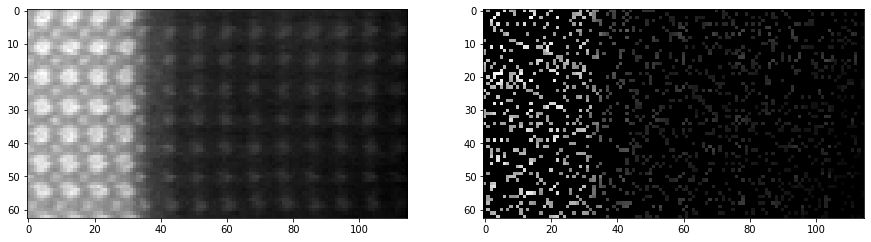

In [13]:
# band to visualize
band = 0

if not test:
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
  ax1.imshow(image_pca[band,:,:])
  ax2.imshow(image_masked_pca[band,:,:]) 
  plt.show()

else:
  f, (ax1) = plt.subplots(1, 1, figsize=(15,15))
  ax1.imshow(image_masked_pca[band,:,:], cmap='grey') 
  plt.show()

# Setup

In [0]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'

In [0]:
INPUT = 'noise'
input_depth = 10
LR = 0.01
num_iter = 1500
param_noise = False
show_every = 50
figsize = 5
reg_noise_std = 0.01
depth = 4

net = skip(input_depth, image_masked_pca.shape[0], 
            num_channels_down = [256, 32, 64, 128, 256, 512, 512][:depth],
            num_channels_up =   [256, 32, 64, 128, 256, 512, 512][:depth],
            num_channels_skip = [256, 32, 64, 128, 256, 512, 512][:depth],
            filter_size_up = 3, filter_size_down = 3, 
            upsample_mode='nearest', filter_skip_size=1,
            need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

#net = ResNet(input_depth, image_masked_pca.shape[0], 8, 64, need_sigmoid=True, act_fun='LeakyReLU')

#net = UNet(num_input_channels=input_depth, num_output_channels=3, 
#                   feature_scale=8, more_layers=1, 
#                   concat_x=False, upsample_mode='deconv', 
#                   pad='reflect', norm_layer=torch.nn.InstanceNorm2d, need_sigmoid=True, need_bias=True)
#        
#LR = 0.001
#param_noise = False

net = net.type(dtype)
net_input = get_noise(input_depth, INPUT, (image_masked_pca.shape[1:])).type(dtype)


In [0]:
#from torchsummary import summary

#summary(net, (50, 63, 115))

In [17]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_masked_var = np_to_torch(image_masked_pca).type(dtype)
mask_var = np_to_torch(mask).type(dtype)

Number of params: 2187430


# Main loop

We define a loss with SNR. Although its the same as mse, we achieve better results, probably due to convergence rate. 

In [0]:
def SNR_loss(img_out, img_ref):
  
  loss = -torch.log10(torch.mean(1/torch.mean(torch.mul((img_ref[0].permute(1,2,0)-img_out[0].permute(1,2,0)),
                            (img_ref[0].permute(1,2,0)-img_out[0].permute(1,2,0))))))
  
  return loss

Starting optimization with ADAM


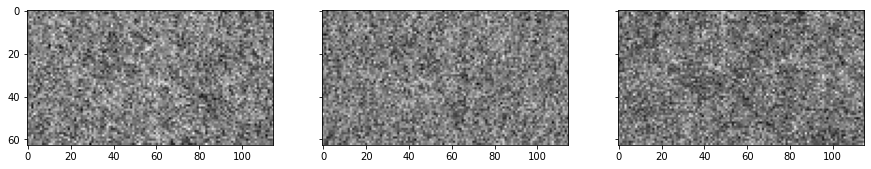

SNR : 15.990731019684885 dB
SSIM : 0.0074815677542600535
SAD : 0.0935075740790302


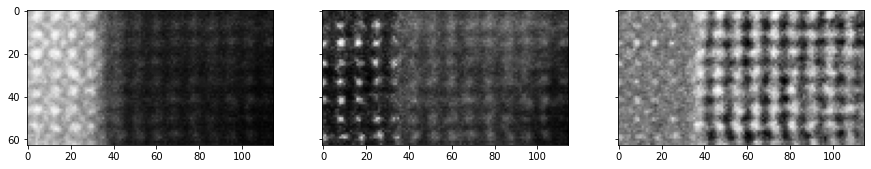

SNR : 28.992938654655987 dB
SSIM : 0.5756361788375849
SAD : 0.022254554954337875


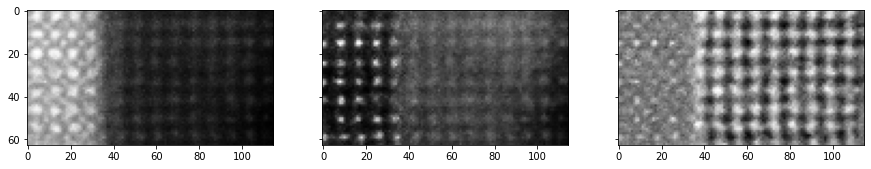

SNR : 29.902396703464976 dB
SSIM : 0.6389717346496685
SAD : 0.020300618782695526


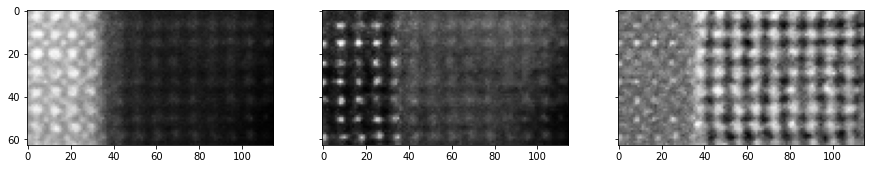

SNR : 30.386599684032966 dB
SSIM : 0.65172605660143
SAD : 0.01959076587548938


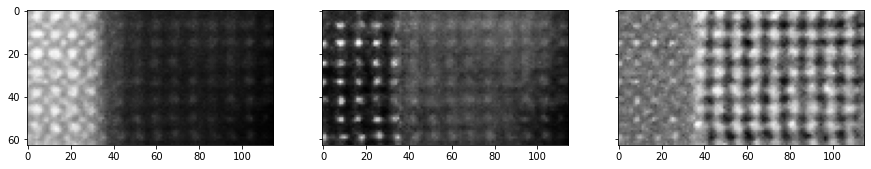

SNR : 30.553455496637323 dB
SSIM : 0.6737600352532243
SAD : 0.019298711835324448


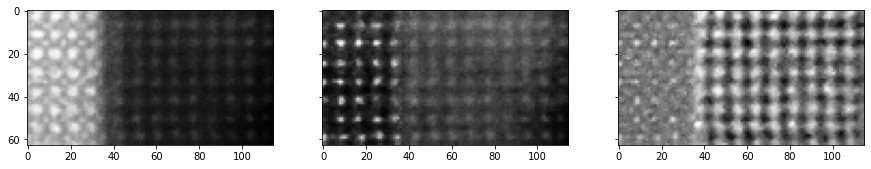

SNR : 30.761969680385015 dB
SSIM : 0.6987791316156271
SAD : 0.019065280511340918


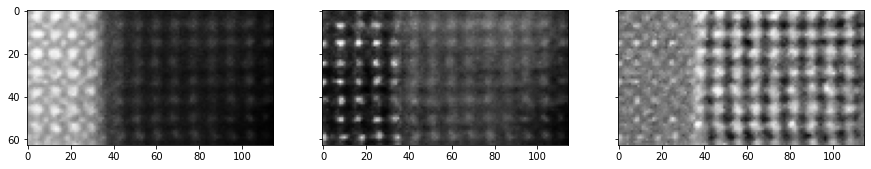

SNR : 30.83836472900318 dB
SSIM : 0.7136868552289837
SAD : 0.018866075629320096


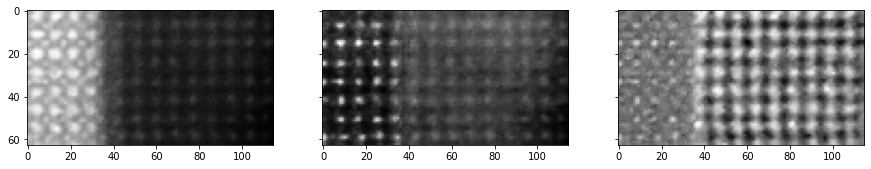

SNR : 30.876756923712357 dB
SSIM : 0.7068414950255378
SAD : 0.018787341464381227


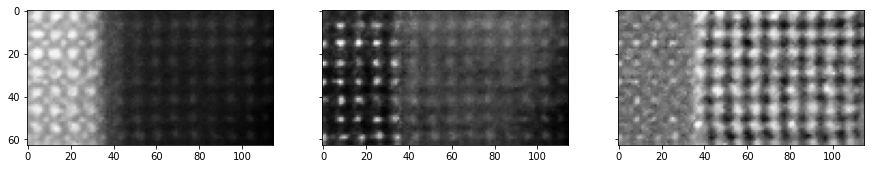

SNR : 30.944673862113316 dB
SSIM : 0.7039139787713059
SAD : 0.01874295628508391


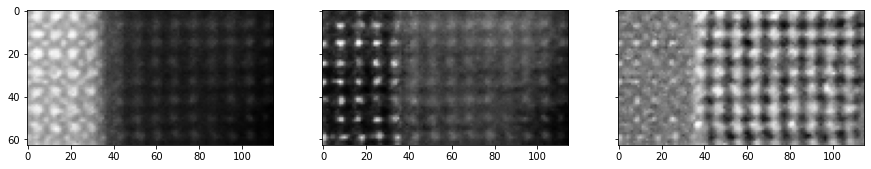

SNR : 30.979376115917304 dB
SSIM : 0.7172982907017244
SAD : 0.018664786744413096


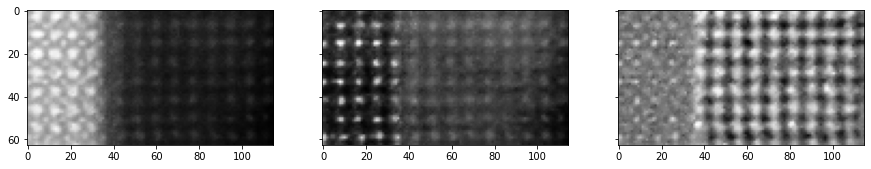

SNR : 31.01350704600788 dB
SSIM : 0.7140452326664231
SAD : 0.018674341348102256


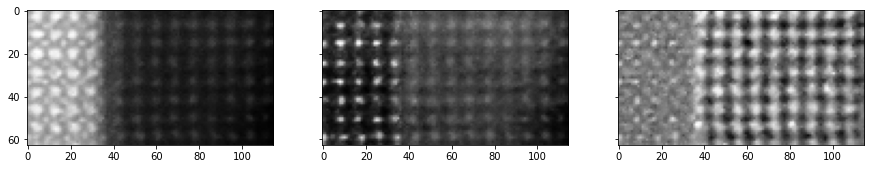

SNR : 30.998700604275676 dB
SSIM : 0.7246604381782692
SAD : 0.01860242963837455


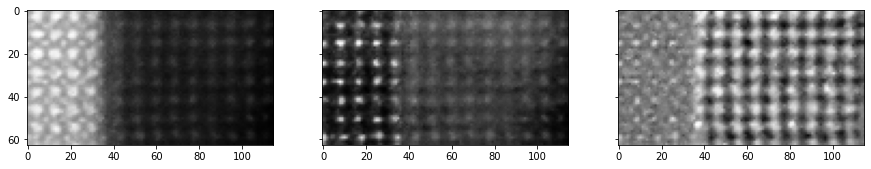

SNR : 30.99523564356756 dB
SSIM : 0.719309704062886
SAD : 0.018541895839432602


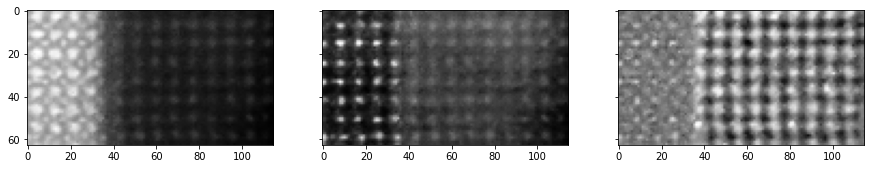

SNR : 31.039788340969263 dB
SSIM : 0.7208864871473044
SAD : 0.018575103672462494


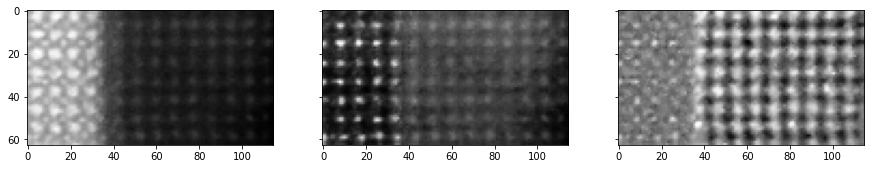

SNR : 31.08176703095044 dB
SSIM : 0.7262039431636947
SAD : 0.01856384415019029


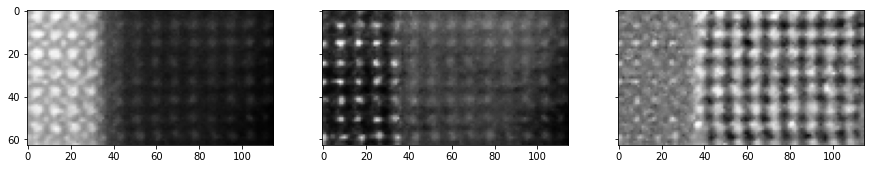

SNR : 31.104357818379064 dB
SSIM : 0.7223941159058648
SAD : 0.01850533573471192


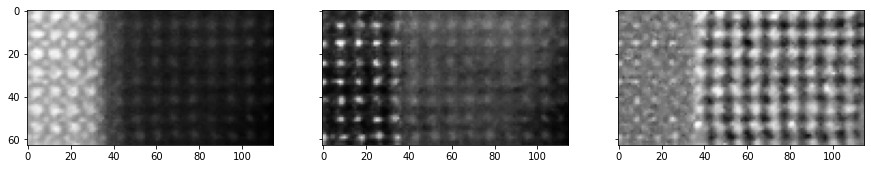

SNR : 31.086419553147955 dB
SSIM : 0.7208263444379317
SAD : 0.018504759745051363


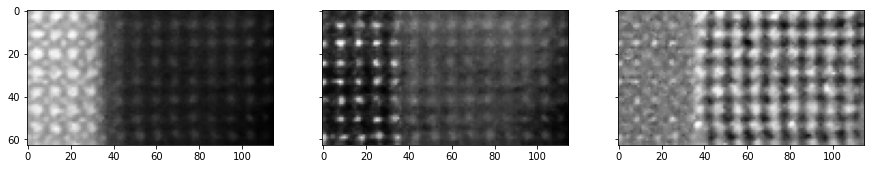

SNR : 31.1325265053514 dB
SSIM : 0.7299625801516588
SAD : 0.018468607698470446


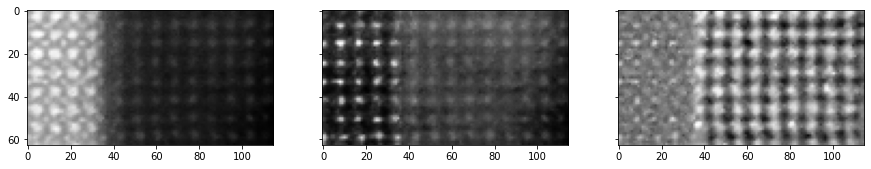

SNR : 31.14371734343615 dB
SSIM : 0.7267093138577668
SAD : 0.01846817812011816


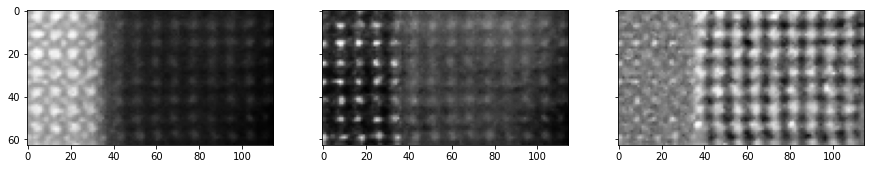

SNR : 31.151798015031538 dB
SSIM : 0.7309169540864366
SAD : 0.018430229495957687


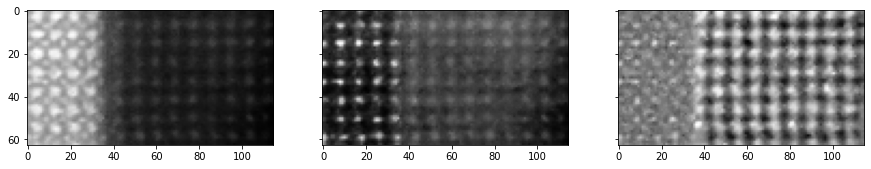

SNR : 31.158452790892422 dB
SSIM : 0.7282519343266265
SAD : 0.018447611766666417


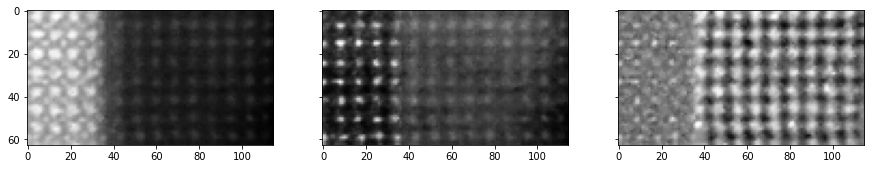

SNR : 31.10204962818898 dB
SSIM : 0.7271064352540978
SAD : 0.018466149443988125


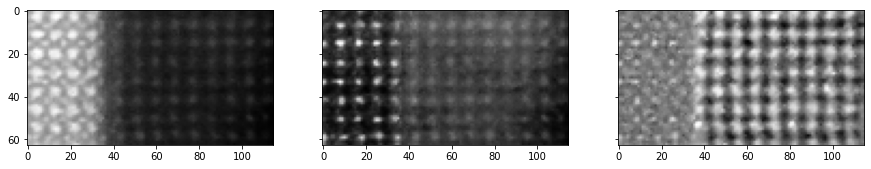

SNR : 31.15777586545642 dB
SSIM : 0.7304576426490474
SAD : 0.01846089282376074


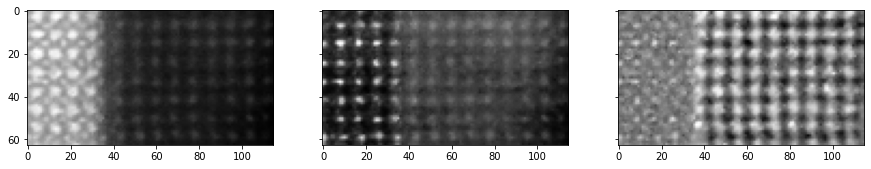

SNR : 31.177538423609885 dB
SSIM : 0.732349604292832
SAD : 0.01842887297877376


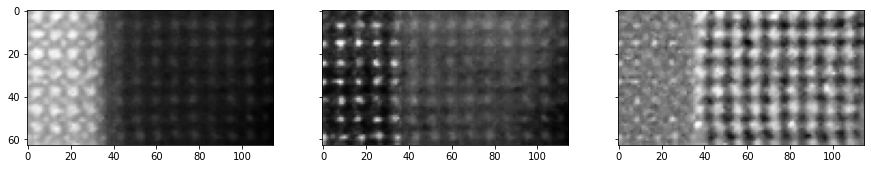

SNR : 31.105464658676233 dB
SSIM : 0.7285844709762738
SAD : 0.018465759248844783


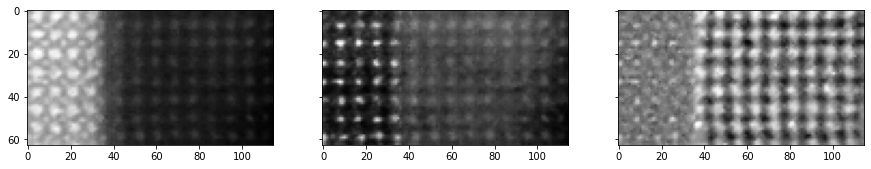

SNR : 31.141120594061462 dB
SSIM : 0.7264323211795342
SAD : 0.018456907422193688


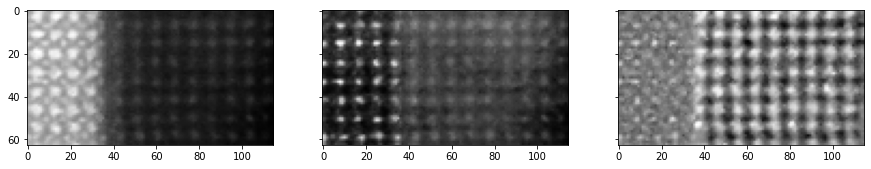

SNR : 31.144391679844535 dB
SSIM : 0.7309123249146594
SAD : 0.018433783033165098


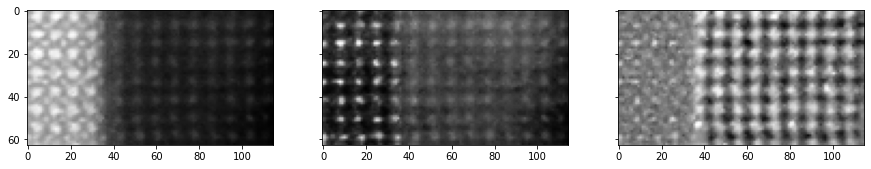

SNR : 31.131891268567994 dB
SSIM : 0.7311829620048266
SAD : 0.018444518925202602


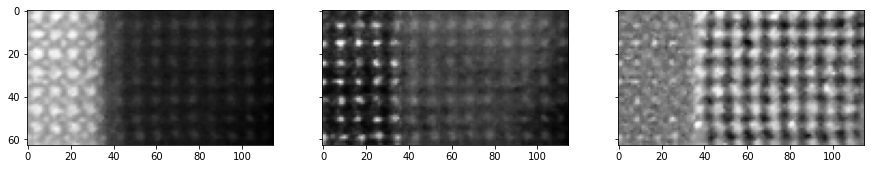

SNR : 31.08456869485618 dB
SSIM : 0.729265855379705
SAD : 0.01848826381230799


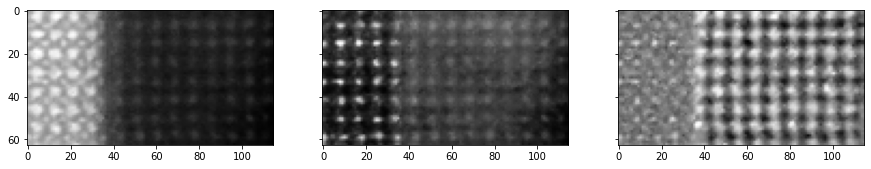

SNR : 31.126489369782323 dB
SSIM : 0.7269267545428405
SAD : 0.0184682918267299


In [19]:
import inpystem.tools.metrics as mt

i = 0
def closure():
    
    global i
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
        
    out = net(net_input)

    #total_loss = mse(out * mask_var, img_masked_var * mask_var)
    total_loss = SNR_loss(out * mask_var, img_masked_var * mask_var)
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = out.detach().cpu().numpy()[0]
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))
        ax1.imshow(out_np[0,:,:])
        ax2.imshow(out_np[1,:,:])
        ax3.imshow(out_np[3,:,:])
        plt.show()

        # Metrics computation
        if not test:
          out_np_transposed = out_np.transpose(1,2,0)
          out_np_inv = inv_pca_and_norm(out_np_transposed.reshape(-1, out_np_transposed.shape[-1]), pca_masked, image_masked_scalers).reshape(out_np_transposed.shape[0], out_np_transposed.shape[1], -1)
      
          SNR = mt.SNR(out_np_inv, img)
          SSIM = mt.SSIM(out_np_inv, img)
          SAD = mt.aSAD(out_np_inv, img)
          
          print('SNR : ' + str(SNR) + ' dB')
          print('SSIM : ' + str(SSIM))
          print('SAD : ' + str(SAD))

    #if  PLOT and i % show_every == 0:
    #    out_np = torch_to_np(out)
    #    plot_image_grid([np.clip(out_np[0], 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

# Output

In [0]:
out_np = torch_to_np(net(net_input))
out_np_transposed = out_np.transpose(1,2,0)
out_np_inv = inv_pca_and_norm(out_np_transposed.reshape(-1, out_np_transposed.shape[-1]), pca_masked, image_masked_scalers).reshape(out_np_transposed.shape[0], out_np_transposed.shape[1], -1)
np.save('result.npy', out_np_inv)

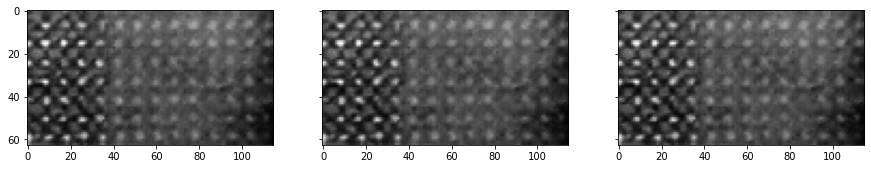

In [21]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))
ax1.imshow(out_np_inv[:,:,0])
ax2.imshow(out_np_inv[:,:,1])
ax3.imshow(out_np_inv[:,:,3])
plt.show()

In [22]:
if not test:
  SNR = mt.SNR(out_np_inv, img)
  SSIM = mt.SSIM(out_np_inv, img)
  SAD = mt.aSAD(out_np_inv, img)

  print('SNR = ', SNR)
  print('SSIM = ', SSIM)
  print('SAD = ', SAD)

SNR =  31.157399990088933
SSIM =  0.7361305647172276
SAD =  0.018455000750552945
